In [1]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
# from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/
! mkdir data

/content/drive/MyDrive
mkdir: cannot create directory ‘data’: File exists


In [4]:
!pwd

/content/drive/MyDrive


In [5]:
%cd data/

/content/drive/MyDrive/data


In [6]:
%cp /data.csv /content/drive/MyDrive/data

cp: cannot stat '/data.csv': No such file or directory


In [7]:
! ls

In [8]:
path='/content/drive/MyDrive/Final_nflx_data_2018-2022[1].csv'

In [9]:
#Read the csv file
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df['date']) #convert to datetime
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261
...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433


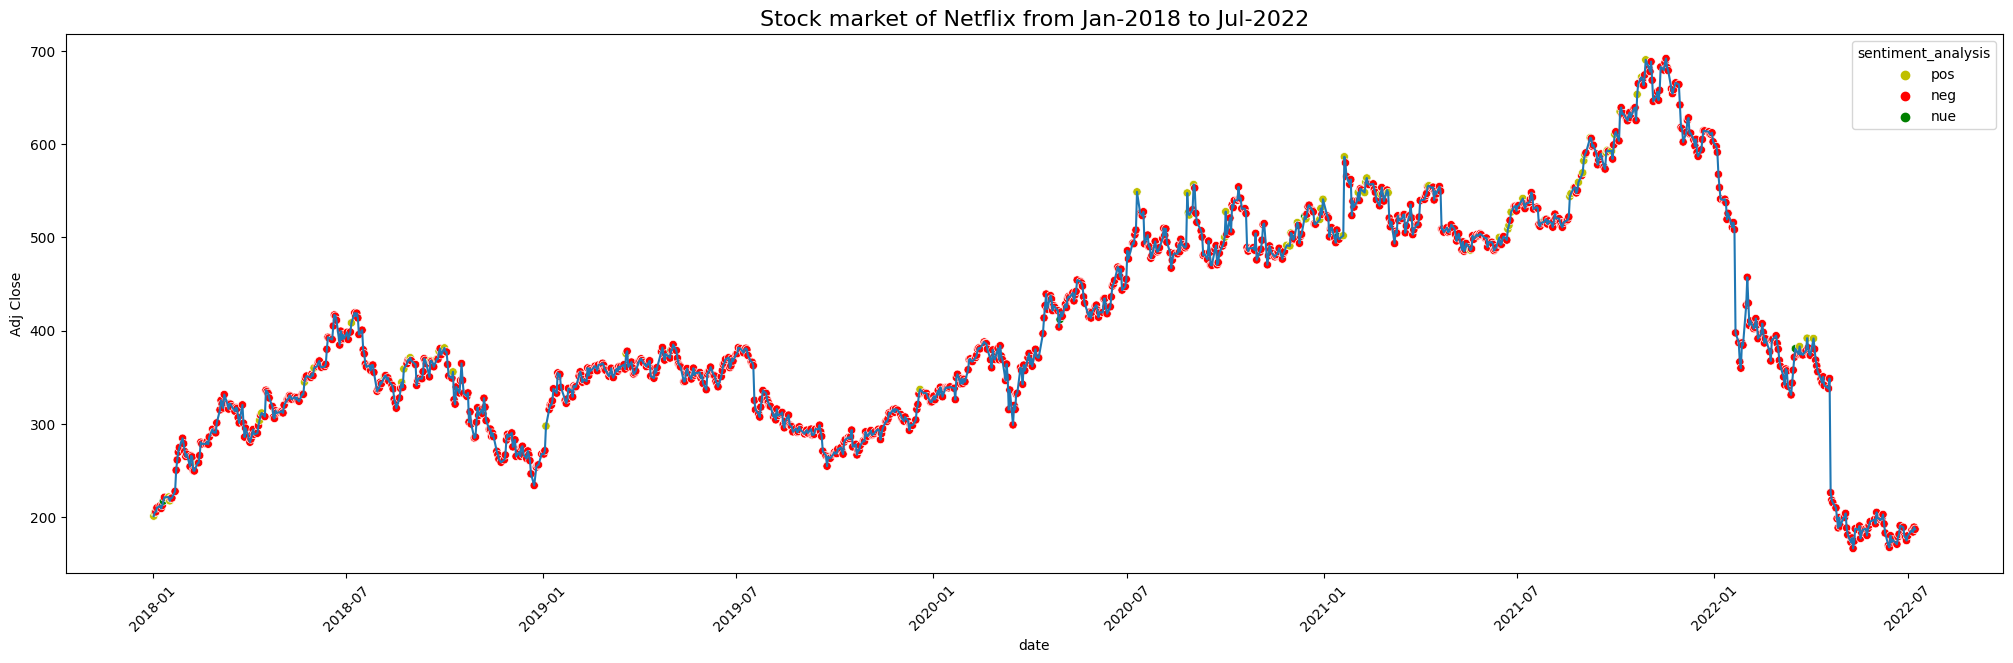

In [10]:
import seaborn as sns #for graphs
plt.figure(figsize=(25,7));
sns.lineplot(x=df["date"],y=df["Adj Close"]) # adjusted close values v/s date
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg') #segregating on the basis of sentiments
sns.scatterplot(x=df["date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Netflix from Jan-2018 to Jul-2022",fontsize=16);

In [11]:
# df=df.drop(list(range(14)),axis=0,inplace=False)
# df

In [12]:
# mapping = {'pos': 1, 'neu': 0, 'neg': -1}
# df.replace({'sentiment_analysis': mapping})
# df

In [13]:
df=df.replace({'pos': 1, 'nue': 0, 'neg': -1})

In [14]:
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count,sentiment_analysis
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480,1
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337,1
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216,-1
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304,-1
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261,-1
...,...,...,...,...,...,...,...,...,...,...,...
1132,2022-07-01,176.490005,180.100006,174.270004,179.949997,179.949997,5194700,-0.062315,-21,337,-1
1133,2022-07-05,176.279999,185.919998,172.679993,185.880005,185.880005,7334300,-0.058824,-25,425,-1
1134,2022-07-06,185.199997,186.220001,180.820007,184.059998,184.059998,5753400,-0.014870,-8,538,-1
1135,2022-07-07,184.270004,190.210007,183.500000,189.270004,189.270004,6334500,-0.055427,-24,433,-1


In [15]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean'
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2018-01-02,196.100006,201.649994,195.419998,201.070007,10966900.0,201.070007,0.020833
2018-01-03,202.050003,206.210007,201.500000,205.050003,8591400.0,205.050003,0.071217
2018-01-04,206.199997,207.050003,204.000000,205.630005,6029600.0,205.630005,-0.018519
2018-01-05,207.250000,210.020004,205.589996,209.990005,7033200.0,209.990005,-0.019737
2018-01-08,210.020004,212.500000,208.440002,212.050003,5580200.0,212.050003,-0.007663
...,...,...,...,...,...,...,...
2022-07-01,176.490005,180.100006,174.270004,179.949997,5194700.0,179.949997,-0.062315
2022-07-05,176.279999,185.919998,172.679993,185.880005,7334300.0,185.880005,-0.058824
2022-07-06,185.199997,186.220001,180.820007,184.059998,5753400.0,184.059998,-0.014870


In [16]:
scaler = MinMaxScaler() # scaling values between 0 and 1
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled
# df_for_training_scaled=df_for_training.copy()
# df_for_training_scaled=df_for_training_scaled.to_numpy()

array([[0.06082629, 0.05594312, 0.06249759, ..., 0.07427889, 0.066055  ,
        0.8357873 ],
       [0.0720869 , 0.06456433, 0.07411439, ..., 0.05631581, 0.07363132,
        0.98677344],
       [0.07994094, 0.06615243, 0.07889104, ..., 0.03694397, 0.07473542,
        0.71785961],
       ...,
       [0.04019756, 0.02677103, 0.03460201, ..., 0.0348554 , 0.03367472,
        0.72879365],
       [0.03843751, 0.03431458, 0.03972256, ..., 0.03924957, 0.04359249,
        0.60725335],
       [0.04174946, 0.03374739, 0.03828956, ..., 0.03544446, 0.03923323,
        0.6444625 ]])

In [17]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1132, 5, 7).
TrainY shape = (1132, 1, 2).


In [18]:
trainX

array([[[0.06082629, 0.05594312, 0.06249759, ..., 0.07427889,
         0.066055  , 0.8357873 ],
        [0.0720869 , 0.06456433, 0.07411439, ..., 0.05631581,
         0.07363132, 0.98677344],
        [0.07994094, 0.06615243, 0.07889104, ..., 0.03694397,
         0.07473542, 0.71785961],
        [0.08192811, 0.07176754, 0.08192898, ..., 0.044533  ,
         0.08303512, 0.7142086 ],
        [0.08717046, 0.07645625, 0.08737436, ..., 0.03354569,
         0.08695654, 0.75039139]],

       [[0.0720869 , 0.06456433, 0.07411439, ..., 0.05631581,
         0.07363132, 0.98677344],
        [0.07994094, 0.06615243, 0.07889104, ..., 0.03694397,
         0.07473542, 0.71785961],
        [0.08192811, 0.07176754, 0.08192898, ..., 0.044533  ,
         0.08303512, 0.7142086 ],
        [0.08717046, 0.07645625, 0.08737436, ..., 0.03354569,
         0.08695654, 0.75039139],
        [0.09112587, 0.07736373, 0.08766095, ..., 0.03767217,
         0.08174066, 0.69780666]],

       [[0.07994094, 0.06615243, 0.0

In [19]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((905, 5, 6), (905, 5, 7))

In [20]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((814, 5, 6), (814, 5, 7))

In [21]:
def build_model(input_shape):  #LSTM model
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [22]:
cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
#applying model on data which doesn't consider sentimental analysis
cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))
#applying model on data which considers sentimental analysis
history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )
#training the model

history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            1664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           657408    
 l)                                                              
                                                        

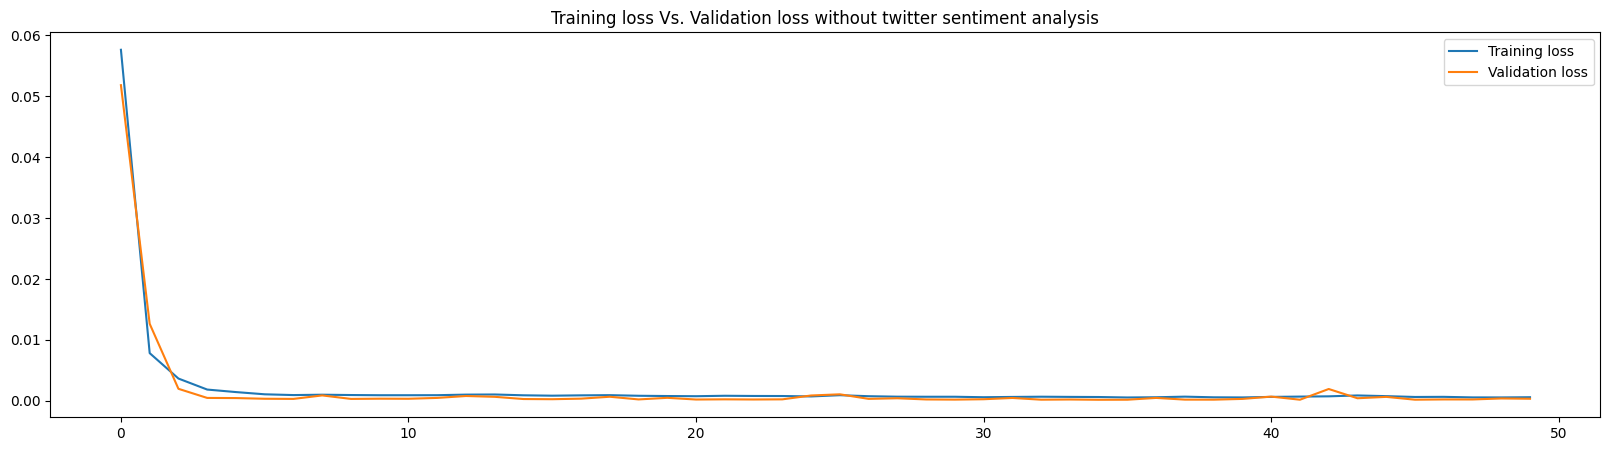

In [23]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()

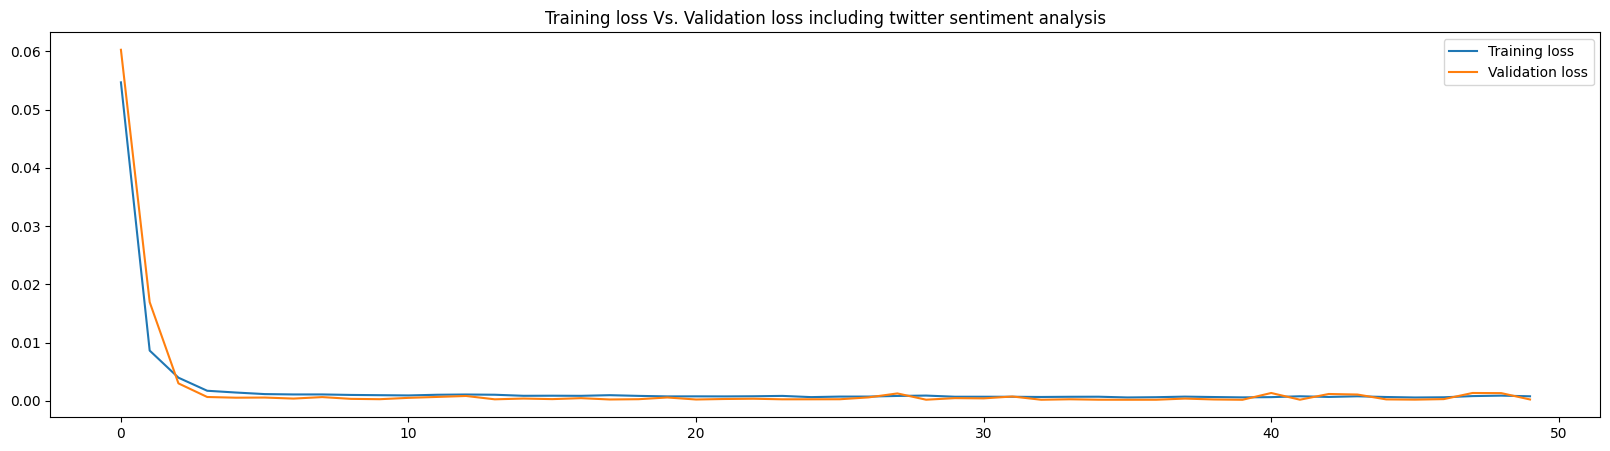

In [24]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

In [25]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [26]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

26/26 [==============================] - 2s 11ms/step


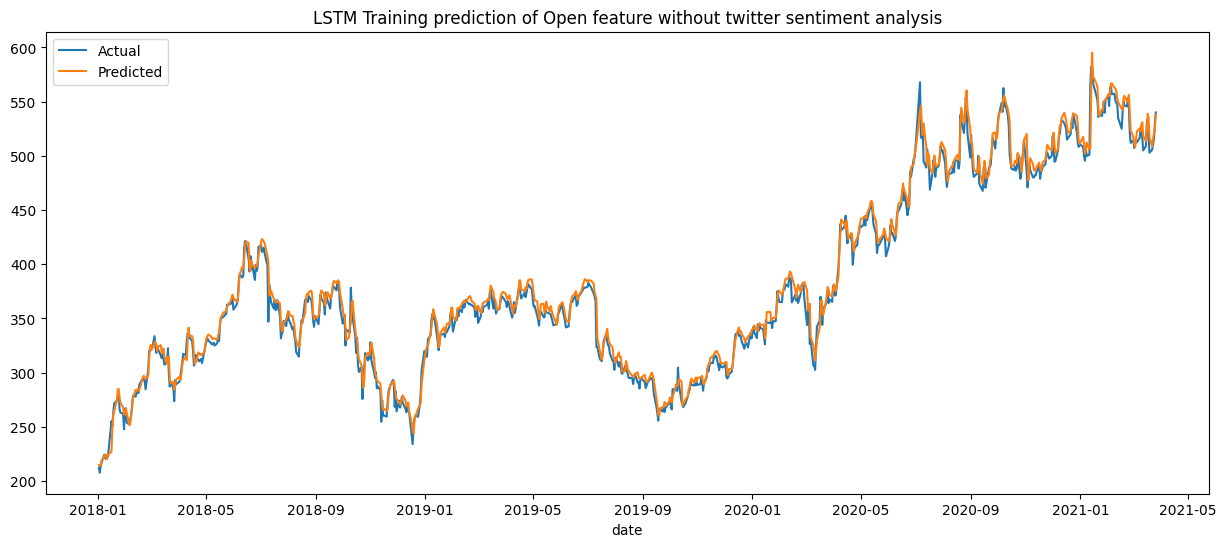

Mean square error for Open =77.08932740679529


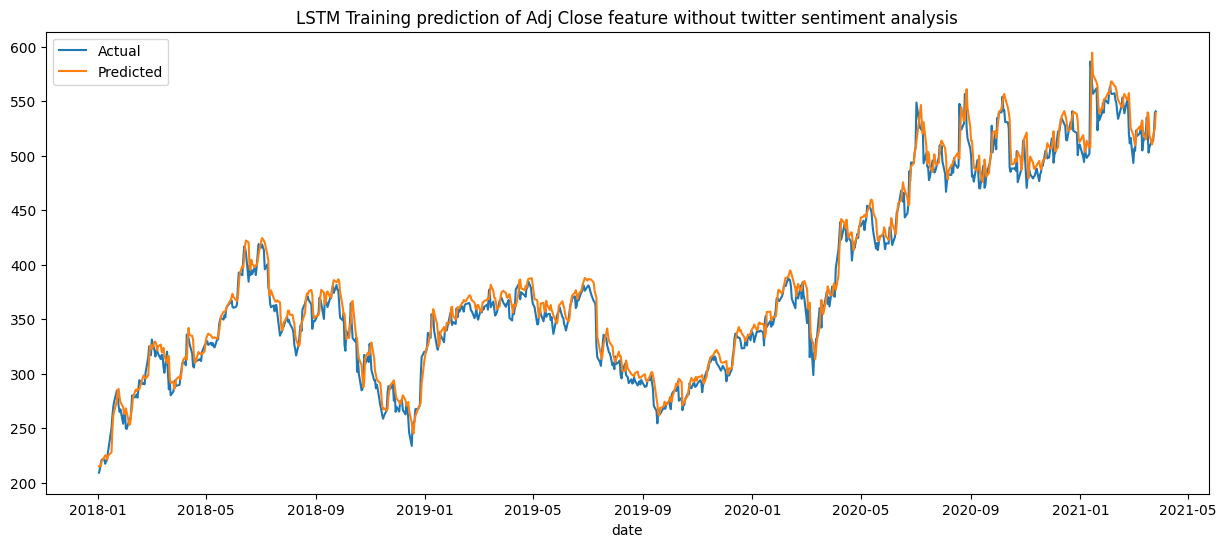

Mean square error for Adj Close =153.55813794729076
Total mean square error 115.32373267704313


In [27]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

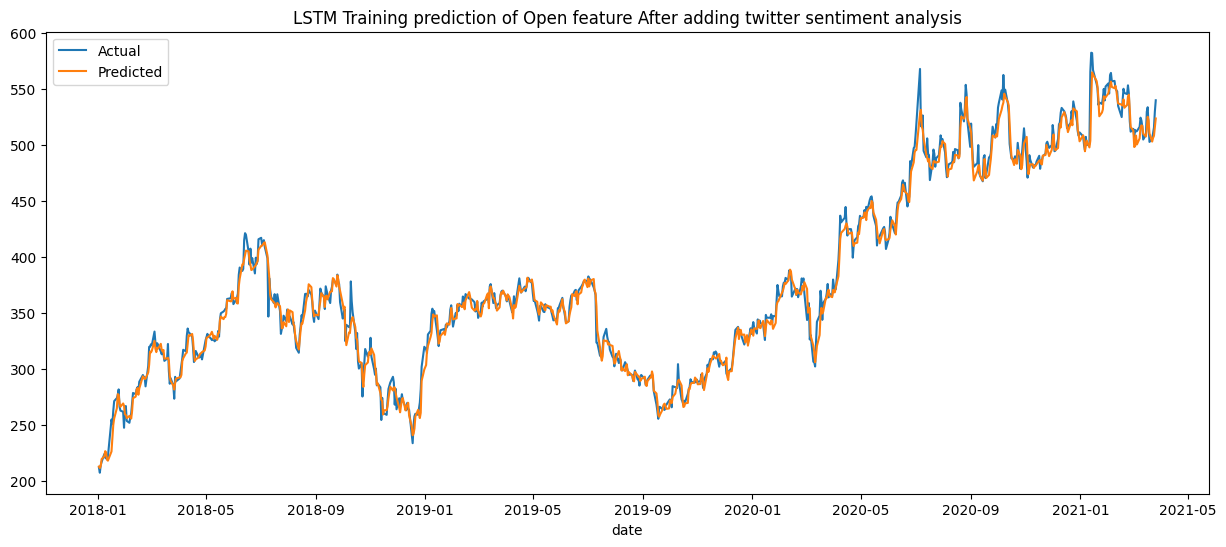

Mean square error for Open =67.59565442272881


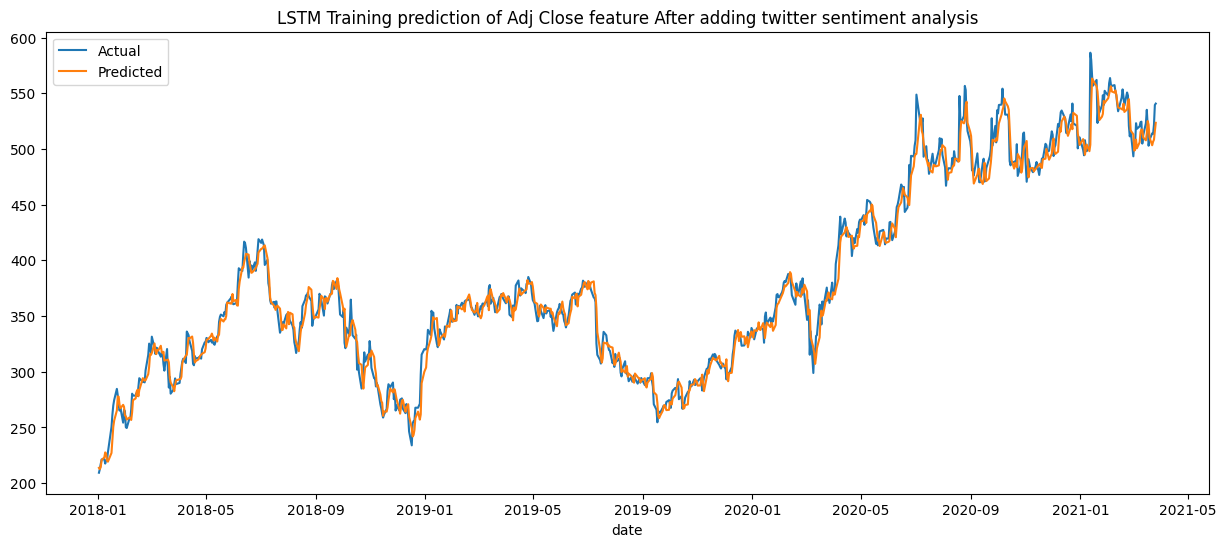

Mean square error for Adj Close =122.68658201393029
Total mean square error 95.14111821832962


In [28]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_twitter)

In [29]:
validation_dates= df_for_training.index[X_train_lstm_without_twitter.shape[0]:X_train_lstm_without_twitter.shape[0] + X_val_lstm_without_twitter.shape[0]]
#Make prediction
validation_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_val_lstm_without_twitter)

validation_prediction_twitter = cnn_lstm_model_twitter.predict(X_val_lstm_twitter)

validation_prediction_without_twitter=validation_prediction_without_twitter.reshape(validation_prediction_without_twitter.shape[0], validation_prediction_without_twitter.shape[2])


validation_prediction_twitter=validation_prediction_twitter.reshape(validation_prediction_twitter.shape[0], validation_prediction_twitter.shape[2])


y_val_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(validation_prediction_without_twitter)
y_val_pred_lstm_twitter = scaler_for_inference.inverse_transform(validation_prediction_twitter)

y_val_actual_lstm_reshaped_without_twitter=y_val_lstm_without_twitter.reshape(y_val_lstm_without_twitter.shape[0], y_val_lstm_without_twitter.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_twitter)

3/3 [==============================] - 0s 11ms/step


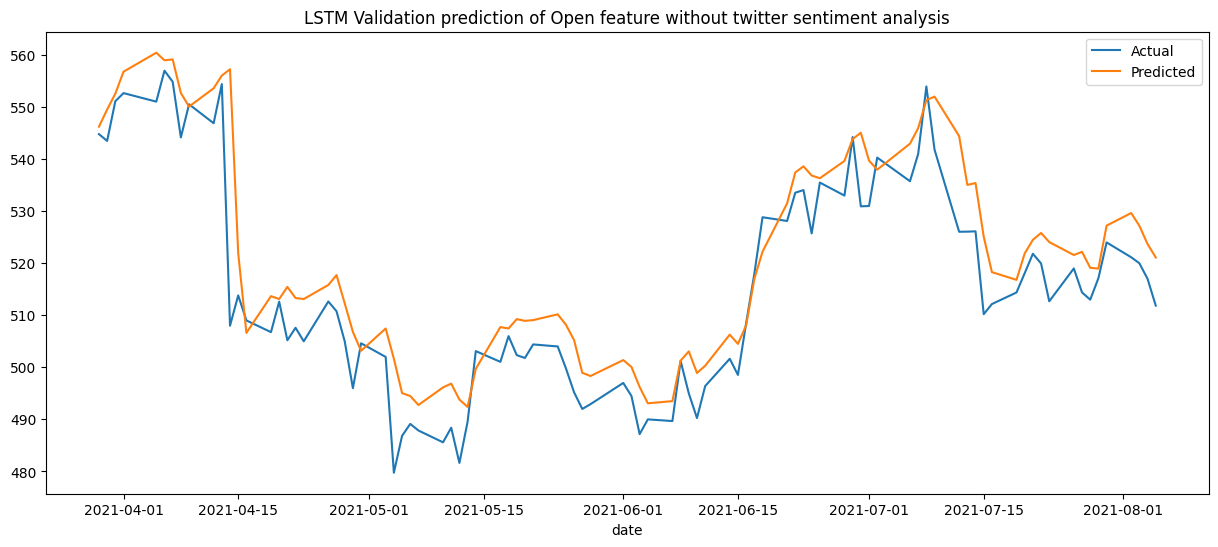

Mean square error for Open =78.39145263955068


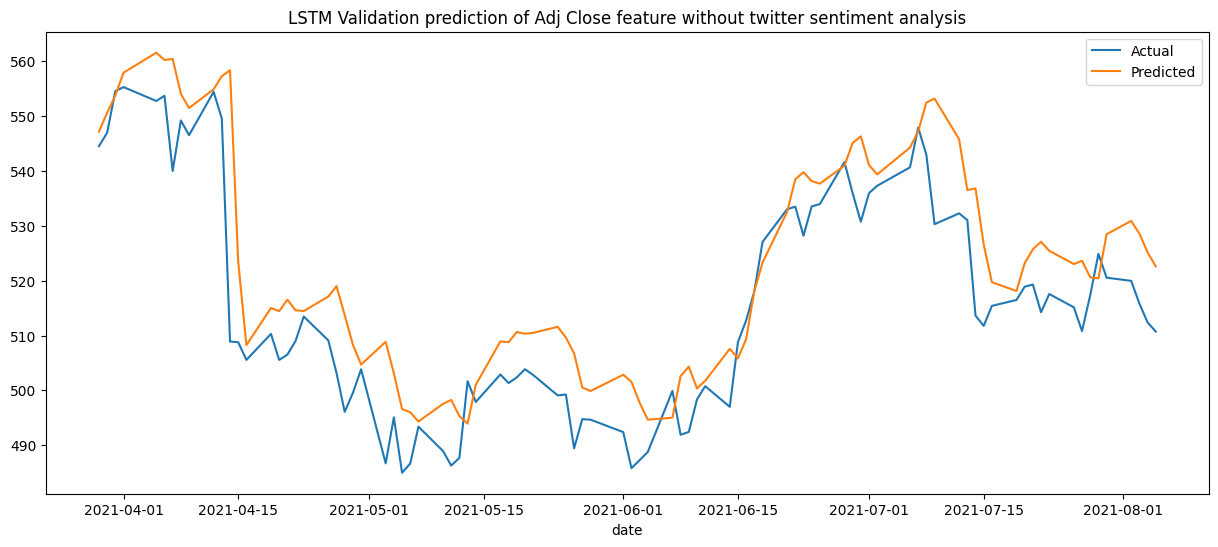

Mean square error for Adj Close =116.39455622301458
Total mean square error 97.3930044312826


In [30]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_twitter)

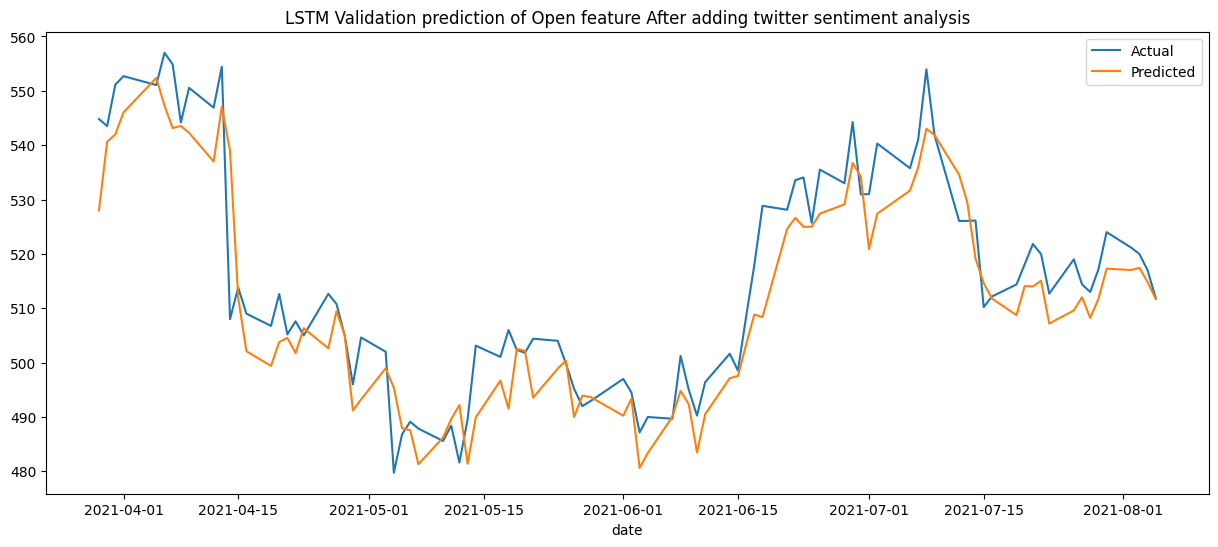

Mean square error for Open =59.72587003188672


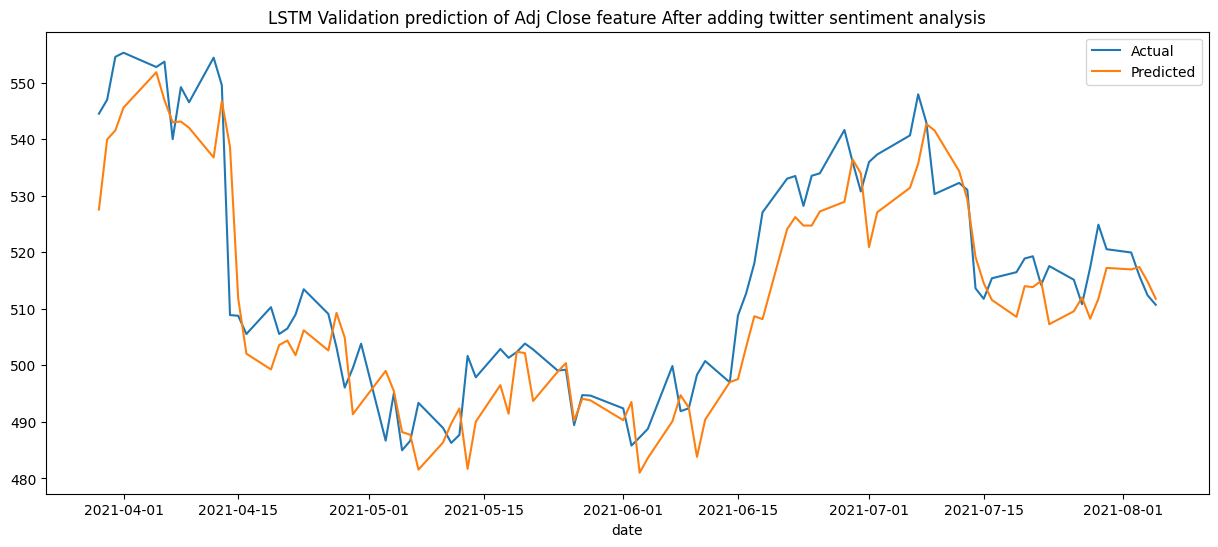

Mean square error for Adj Close =71.28728750308271
Total mean square error 65.50657876748471


In [31]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_twitter)


In [32]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

8/8 [==============================] - 0s 9ms/step


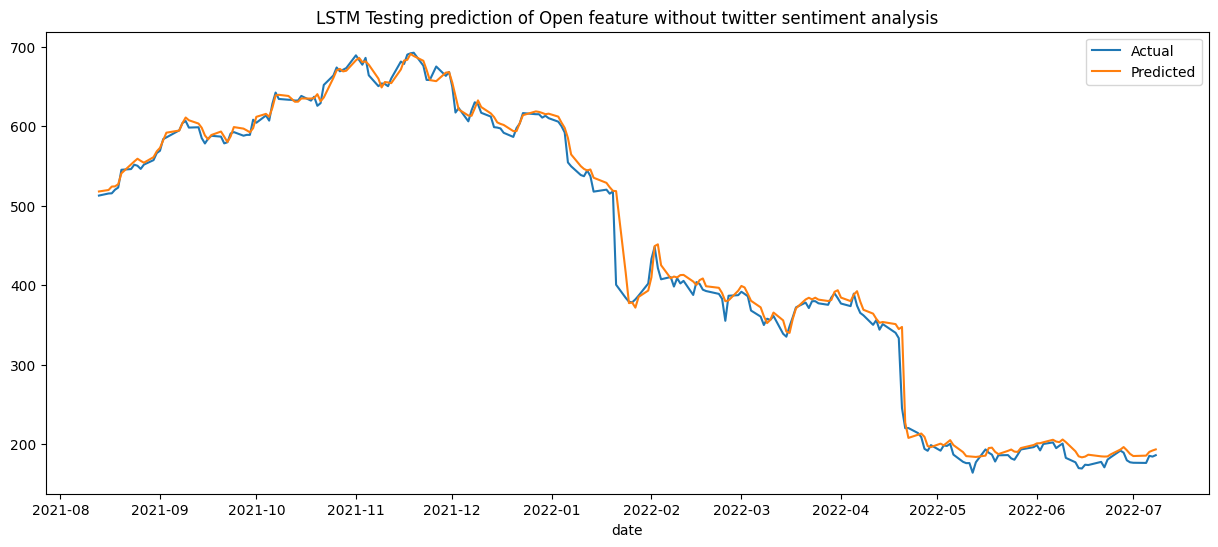

Mean square error for Open =186.31240429537843


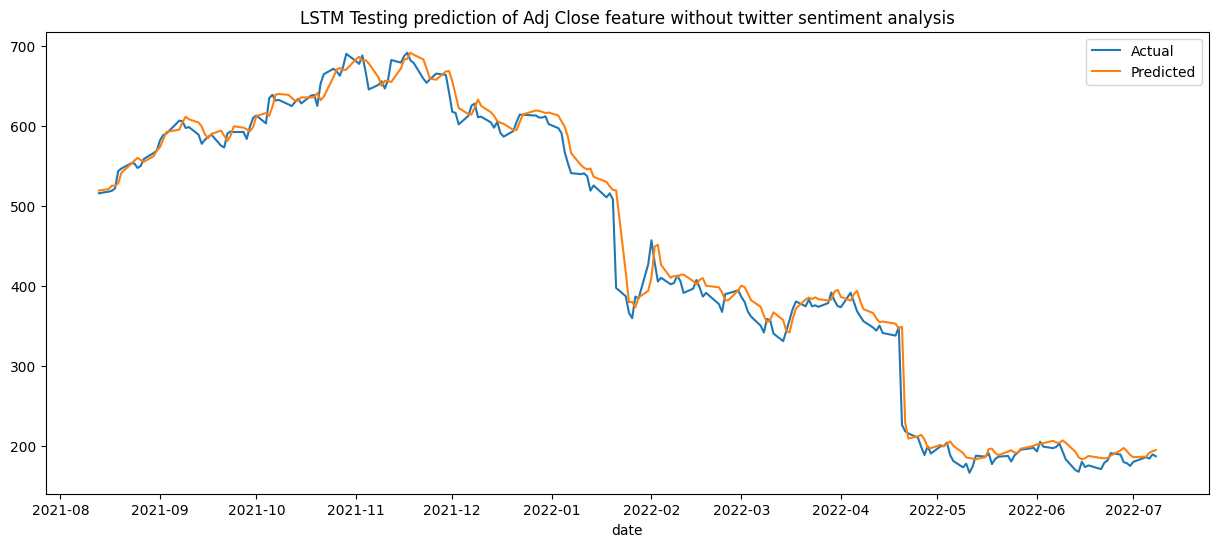

Mean square error for Adj Close =329.77922472227743
Total mean square error 258.045814508828


In [33]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

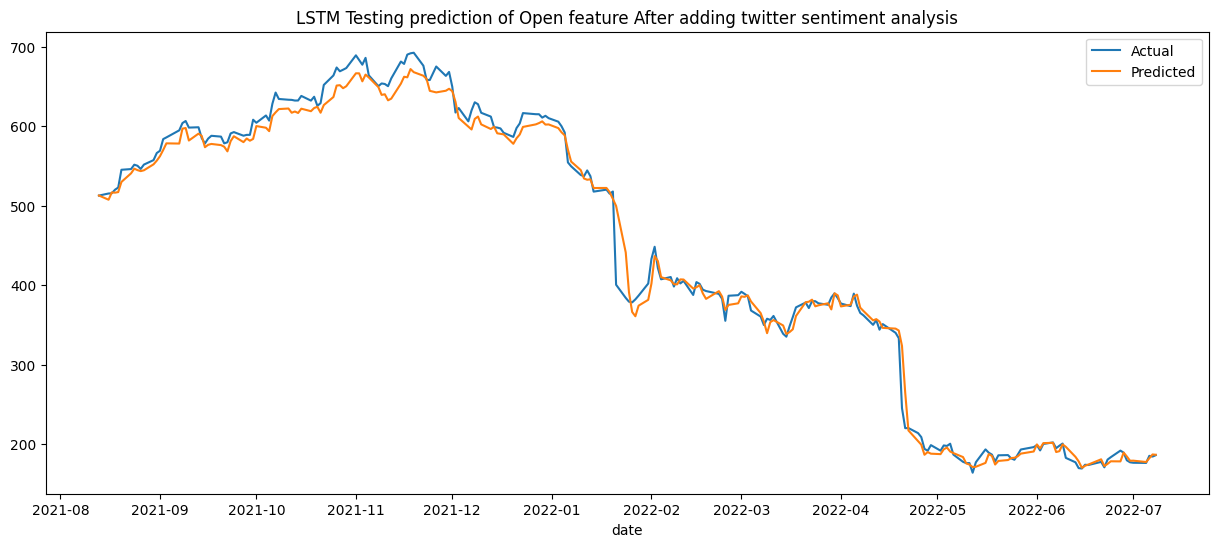

Mean square error for Open =219.84176364558292


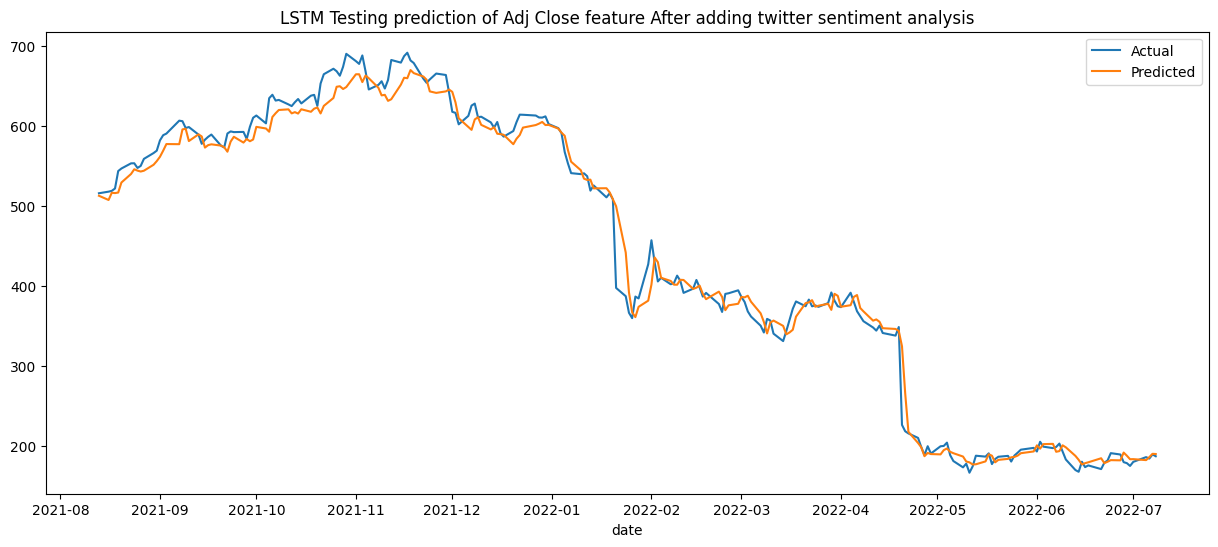

Mean square error for Adj Close =340.70863127105866
Total mean square error 280.2751974583208


In [34]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)